In [18]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
import joblib

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Funçoes

In [20]:
def plot_roc_curve(modelos, legendas, dataloader, device,normalizado):
    plt.figure()
    lw = 2

    for i, modelo in enumerate(modelos):
        modelo.to(device)
        modelo.eval()  # Define o modelo para o modo de avaliação
        all_labels = []
        all_probs = []
        if i ==2 :
            dataloader = normalizado
        with torch.no_grad():  # Desliga o cálculo de gradientes para economizar memória e acelerar o processo
            for _, (data, target) in enumerate(dataloader):

                target, imgs = target.float().to(device), data.float().to(device)

                pred_probs = torch.sigmoid(modelo(imgs)).cpu().numpy()  # Probabilidades previstas pelo modelo
                all_probs.extend(pred_probs)
                all_labels.extend(target.cpu().numpy())


        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)

        # Use a legenda correspondente ao modelo atual
        plt.plot(fpr, tpr, lw=lw, label=f'{legendas[i]} ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


In [21]:
def recuperar_rede(path,Classe):
    modelo = Classe(16)
    checkpoint= torch.load(path,map_location=torch.device('cuda'))
    modelo.load_state_dict(checkpoint)
    return modelo.eval()

# dataloader

In [22]:
teste = torch.load("../data/teste_particle.pt")

In [23]:
y_teste = teste[:,-1]
y_teste= y_teste.unsqueeze(1)
sc = joblib.load('../model/standard_scaler.pkl')
teste_normalizados = torch.tensor(sc.transform(teste[:, 0:-1]))


In [24]:
teste_normalizado = torch.cat((teste_normalizados, y_teste), dim=1)


In [25]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtendo a imagem (vetor) e o rótulo (target) da linha idx do tensor
        image = self.data[idx, 0:-1]
        label = self.data[idx, -1].long()


        # Aplicando transformações, se necessário
        if self.transform:
            image = self.transform(image)

        return image, label


In [26]:
dataset_teste_normalizado = CustomDataset(teste_normalizado)
batch_size = 128  
test_dataloader_normalizado = DataLoader(dataset_teste_normalizado, batch_size=batch_size, shuffle=True)

In [27]:
dataset_teste = CustomDataset(teste)
batch_size = 128  
test_dataloader = DataLoader(dataset_teste, batch_size=batch_size, shuffle=True)

# Incluindo os modelos

## Modelo com 1760 Neurônios SDG

In [28]:
class MLPClassification1760(nn.Module):
  def __init__(self,entrada):
    super().__init__()


    self.layers = nn.Sequential(
        nn.Linear(entrada,1000),
        nn.ReLU(),
        nn.Linear(1000,500),
        nn.ReLU(),
        nn.Linear(500,250),
        nn.ReLU(),
        nn.Linear(250,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.layers(x)

In [29]:
path = "../model/particula/1760_neuronios_sgd.pth"
modelo1760NSGD = recuperar_rede(path,MLPClassification1760)

## Modelo com 1760 Neurônios ADAM

In [30]:
path = "../model/particula/1760_neuronios_adam.pth"
modelo1760ADAM = recuperar_rede(path,MLPClassification1760)

## Modelo com 1760 Neurônios ADAM Normalizado

In [31]:
path= "../model/particula/1760_neuronios_adam_normalizado.pth"
modelo1760NADAM = recuperar_rede(path,MLPClassification1760)

# plotando

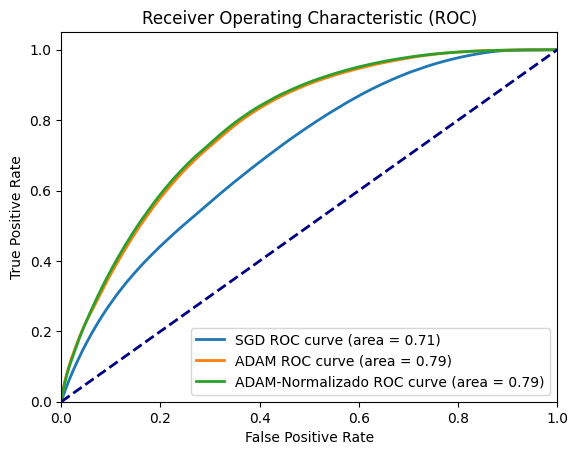

In [32]:
modelos = [modelo1760NSGD,modelo1760ADAM,modelo1760NADAM]
legenda = ["SGD","ADAM","ADAM-Normalizado"]
plot_roc_curve(modelos, legenda,test_dataloader,device,test_dataloader_normalizado)
